In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as pt

class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

In [3]:
def find_sensitivity(model, inputs, loss_function):
    inputs.requires_grad_()
    pre_outputs = model(inputs)
    loss = loss_function(pre_outputs, pre_outputs.max(1)[1])
    loss.backward()
    return torch.sqrt(torch.sum(inputs.grad ** 2)).item()
    
def train_model(model, optimizer, trainloader, loss_function):
    total_train_loss = 0.0
    correct = 0.0
    train_total = 0.0
    total_sensitivity = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        predicted_outputs = model(inputs)
        loss = loss_function(predicted_outputs, labels)
        loss.backward()
        sensitivity = find_sensitivity(model, inputs, loss_function)
        total_sensitivity += sensitivity
        optimizer.step()
        total_train_loss += loss.item()
        predicted = predicted_outputs.argmax(dim=1)
        train_total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    loss_for_training = (total_train_loss / len(trainloader))
    acc_for_training = (100 * correct / train_total)
    train_sensitivity = total_sensitivity / len(trainloader)
    
    return loss_for_training, acc_for_training, train_sensitivity

def test_model(model, optimizer, testloader, loss_function):
    model.eval()
    total_test_loss = 0.0
    actual = 0.0
    test_total = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            predicted_outputs = model(inputs)
            test_loss = loss_function(predicted_outputs, labels)
            total_test_loss += test_loss.item() * inputs.size(0)
            predicted = predicted_outputs.argmax(dim=1)
            test_total += labels.size(0)
            actual += (predicted == labels).sum().item()
    loss_for_testing = (total_test_loss / test_total)
    acc_for_testing = (100 * actual / test_total)
    
    return loss_for_testing, acc_for_testing

def compute_metrics(model, optimizer, trainloader, testloader, loss_function):
    model.train()
    compute_train_losses, compute_test_losses = [], []
    compute_train_accuracy, compute_test_accuracy = [], []
    compute_sensitivities = []
    epoch = 0
    epochs = 10
    while epoch < epochs:
            
        train_loss, train_acc, sensitivity = train_model(model, optimizer, trainloader, loss_function)
        compute_train_losses.append(train_loss)
        compute_train_accuracy.append(train_acc)
        compute_sensitivities.append(sensitivity)
        
                
        test_loss, test_acc = test_model(model, optimizer, testloader, loss_function)
        compute_test_losses.append(test_loss)
        compute_test_accuracy.append(test_acc)
        
        print(f'Epoch: {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}')
        epoch +=1
    return compute_train_losses, compute_test_losses, compute_train_accuracy, compute_test_accuracy, compute_sensitivities



In [4]:
#Training 5 models with different training approach

batch_array = [32, 64, 128, 256, 512]
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
training_set = torchvision.datasets.MNIST(root='./data', train = True, download = True, transform = trans)
testing_set = torchvision.datasets.MNIST(root='./data', train = False, download = True, transform = trans)

train_loader_1 = torch.utils.data.DataLoader(training_set, batch_size=batch_array[0], shuffle=True)
test_loader_1 = torch.utils.data.DataLoader(testing_set, batch_size=batch_array[0], shuffle=False)

train_loader_2 = torch.utils.data.DataLoader(training_set, batch_size=batch_array[1], shuffle=True)
test_loader_2 = torch.utils.data.DataLoader(testing_set, batch_size=batch_array[1], shuffle=False)

train_loader_3 = torch.utils.data.DataLoader(training_set, batch_size=batch_array[2], shuffle=True)
test_loader_3 = torch.utils.data.DataLoader(testing_set, batch_size=batch_array[2], shuffle=False)

train_loader_4 = torch.utils.data.DataLoader(training_set, batch_size=batch_array[3], shuffle=True)
test_loader_4 = torch.utils.data.DataLoader(testing_set, batch_size=batch_array[3], shuffle=False)

train_loader_5 = torch.utils.data.DataLoader(training_set, batch_size=batch_array[4], shuffle=True)
test_loader_5 = torch.utils.data.DataLoader(testing_set, batch_size=batch_array[4], shuffle=False)

train_loaders = [train_loader_1, train_loader_2, train_loader_3, train_loader_4, train_loader_5]
test_loaders = [test_loader_1, test_loader_2, test_loader_3, test_loader_4, test_loader_5]

final_train_loss, final_test_loss, final_train_acc, final_test_acc, final_sens = [], [], [], [], []

for val in range(5):
    model = Model_1()
    loss_function = nn.CrossEntropyLoss()
    if val <= 2:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    tr_loss, te_loss, tr_acc, te_acc, sens = compute_metrics(model, optimizer, train_loaders[val], test_loaders[val], loss_function)
    final_train_loss.append(tr_loss)
    final_test_loss.append(te_loss)
    final_train_acc.append(tr_acc)
    final_test_acc.append(te_acc)
    final_sens.append(sens)

Epoch: 1, Train Loss: 0.21837022138821582, Test Loss: 0.05699141666530631
Epoch: 2, Train Loss: 0.062204755316721275, Test Loss: 0.04841393367150158
Epoch: 3, Train Loss: 0.04369640226904109, Test Loss: 0.03704410291664681
Epoch: 4, Train Loss: 0.034268943235947515, Test Loss: 0.04247493556454574
Epoch: 5, Train Loss: 0.027486716337794013, Test Loss: 0.037555698544362894
Epoch: 6, Train Loss: 0.02362889484432914, Test Loss: 0.03537915730961195
Epoch: 7, Train Loss: 0.018892975915065835, Test Loss: 0.04742781928795571
Epoch: 8, Train Loss: 0.01671112594436187, Test Loss: 0.035661428989711565
Epoch: 9, Train Loss: 0.01327526672156523, Test Loss: 0.048093100302973354
Epoch: 10, Train Loss: 0.011642140574983978, Test Loss: 0.0465689189874673
Epoch: 1, Train Loss: 0.3391328241272982, Test Loss: 0.07545307389404625
Epoch: 2, Train Loss: 0.07627703141990622, Test Loss: 0.05236244606368709
Epoch: 3, Train Loss: 0.05379877725757211, Test Loss: 0.041124687399878165
Epoch: 4, Train Loss: 0.041892

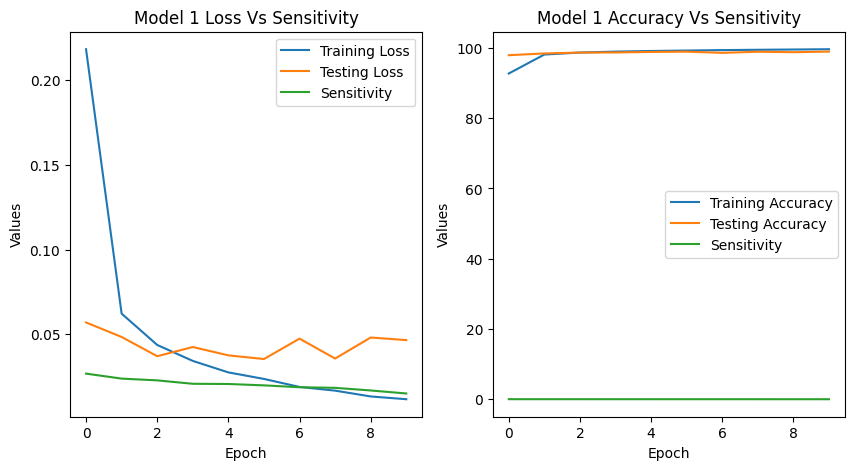

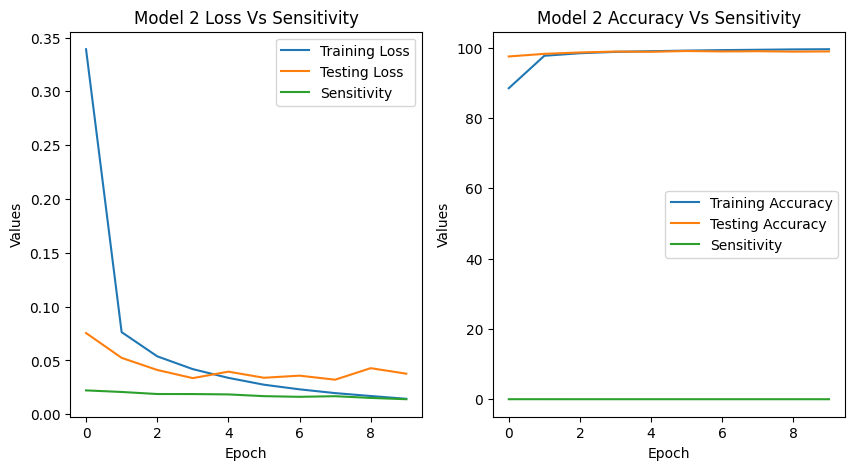

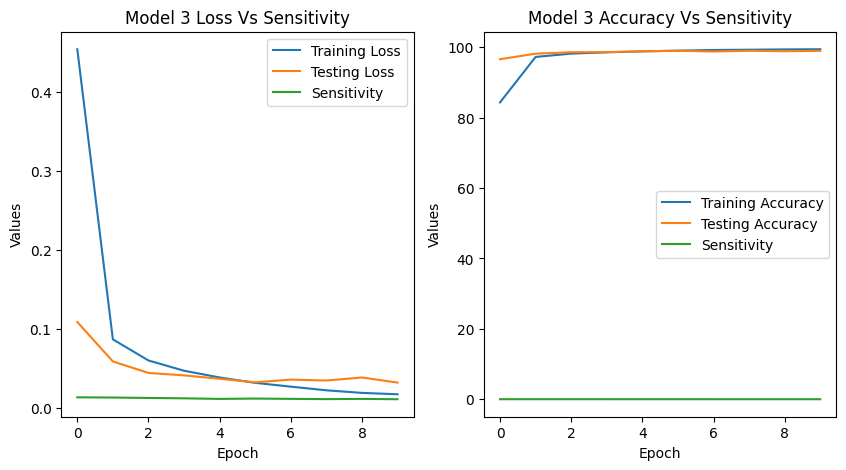

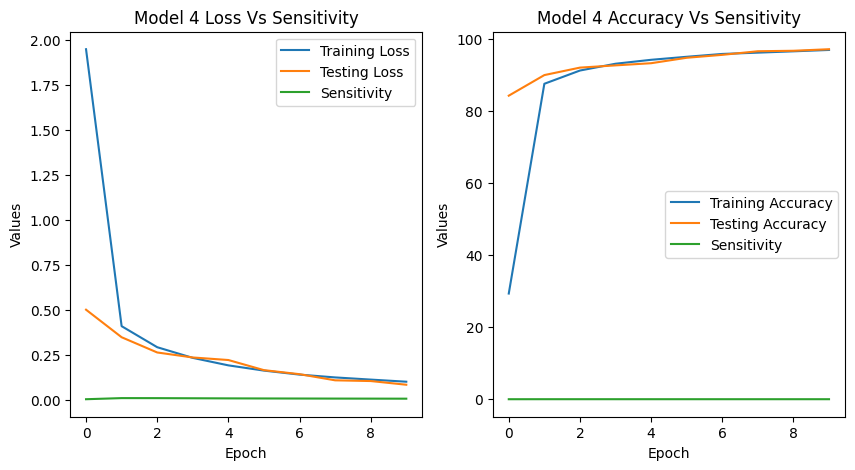

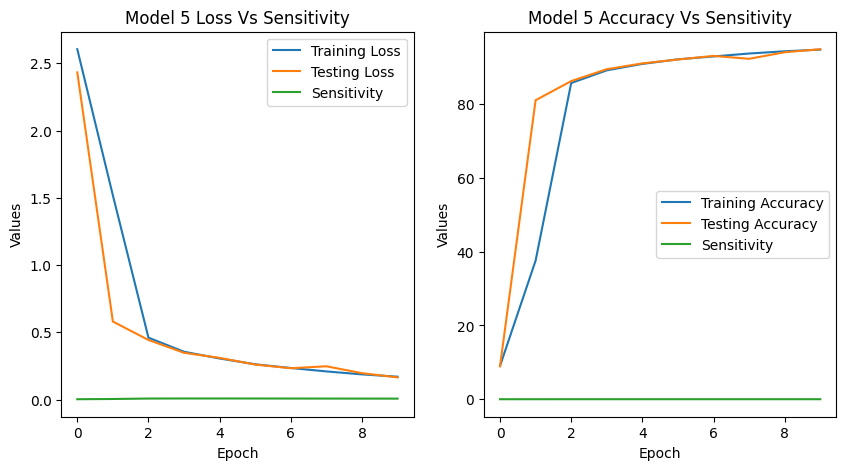

In [5]:
for i in range(5):
    pt.figure(figsize=(10,5))
    pt.subplot(1, 2, 1)
    pt.plot(range(len(final_train_loss[i])), final_train_loss[i], label='Training Loss')
    pt.plot(range(len(final_test_loss[i])), final_test_loss[i], label='Testing Loss')
    pt.plot(range(len(final_sens[i])), final_sens[i], label='Sensitivity')
    pt.title(f'Model {i+1} Loss Vs Sensitivity')
    pt.xlabel('Epoch')
    pt.ylabel('Values')
    pt.legend()
    
    pt.subplot(1, 2, 2)
    pt.plot(range(len(final_train_acc[i])), final_train_acc[i], label='Training Accuracy')
    pt.plot(range(len(final_test_acc[i])), final_test_acc[i], label='Testing Accuracy')
    pt.plot(range(len(final_sens[i])), final_sens[i], label='Sensitivity')
    pt.title(f'Model {i+1} Accuracy Vs Sensitivity')
    pt.xlabel('Epoch')
    pt.ylabel('Values')
    pt.legend()
    
    pt.show()